# Capstone Project (Pembelajaran Mesin)
## Prediksi Kepuasan Penumpang Maskapai Menggunakan Logistic Regression dan XGBoost

**Studi kasus:** Prediksi apakah penumpang merasa **satisfied** atau **neutral or dissatisfied** berdasarkan atribut layanan dan pengalaman penerbangan.

**Tujuan proyek (end-to-end):**
1. Memuat dataset dan memahami struktur data
2. Melakukan preprocessing sesuai kebutuhan model (**missing values, encoding, scaling**)
3. Membangun dan membandingkan minimal 2 algoritma:
   - **Logistic Regression** (baseline)
   - **XGBoost** (advanced)
4. Evaluasi menggunakan metrik yang tepat (**F1-score** dan **ROC-AUC**, bukan hanya accuracy)
5. Menampilkan **Confusion Matrix** & **ROC Curve**
6. Interpretasi fitur (**koefisien Logistic Regression** dan **feature importance XGBoost**)
7. Menyimpan model terbaik untuk deployment (**joblib**)

**Dataset:** Airline Passenger Satisfaction (Kaggle)  
https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

**File yang digunakan (sudah di-upload pada environment ini):**
- `train.csv`
- `test.csv`

> Notebook ini dibuat agar **runnable dari awal sampai akhir**.


In [37]:
# ============================================================
# Setup & Import Library
# ============================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

import joblib

# XGBoost
try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost belum terpasang. Install: pip install xgboost") from e

RANDOM_STATE = 42
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Load Data

Pada tahap ini, kita memuat dataset `train.csv` dan `test.csv`.

Walau ada file `test.csv`, kita tetap akan membuat **validation split** dari train untuk evaluasi yang adil.

Mengapa?
- Validasi dari train digunakan untuk **pemilihan model** secara objektif.
- Test dipakai sebagai evaluasi akhir (simulasi data baru).


In [38]:
TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)

df_train.head()

Train shape: (1000, 25)
Test shape : (1000, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## 2. Data Cleaning Ringan & Validasi Target

Langkah yang dilakukan:
- Menghapus kolom index yang tidak informatif (`Unnamed: 0`) jika ada.
- Memastikan kolom target `satisfaction` ada.
- Melihat distribusi target untuk mengetahui apakah data **imbalanced**.


In [39]:
from IPython.display import display

TARGET = "satisfaction"

for df in [df_train, df_test]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)

assert TARGET in df_train.columns, "Target 'satisfaction' tidak ditemukan di train."
assert TARGET in df_test.columns,  "Target 'satisfaction' tidak ditemukan di test."

print("Unique labels (train):", df_train[TARGET].unique())

print("\nDistribusi target (train):")
display(df_train[TARGET].value_counts())
display((df_train[TARGET].value_counts(normalize=True) * 100).round(2))

Unique labels (train): ['neutral or dissatisfied' 'satisfied']

Distribusi target (train):


satisfaction
neutral or dissatisfied    560
satisfied                  440
Name: count, dtype: int64

satisfaction
neutral or dissatisfied    56.0
satisfied                  44.0
Name: proportion, dtype: float64

## 3. EDA Singkat: Missing Values & Ringkasan Data

Tujuan EDA singkat:
- Mengidentifikasi **missing values**
- Memahami tipe fitur: numerik vs kategorikal
- Menyiapkan strategi preprocessing


In [40]:
print("Missing values (train) - top 10:")
display(df_train.isna().sum().sort_values(ascending=False).head(10))

print("\nInfo data:")
df_train.info()

print("\nStatistik numerik:")
display(df_train.describe(include=[np.number]).T)

Missing values (train) - top 10:


Arrival Delay in Minutes      1
id                            0
Gender                        0
Departure Delay in Minutes    0
Cleanliness                   0
Inflight service              0
Checkin service               0
Baggage handling              0
Leg room service              0
On-board service              0
dtype: int64


Info data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 1000 non-null   int64  
 1   Gender                             1000 non-null   object 
 2   Customer Type                      1000 non-null   object 
 3   Age                                1000 non-null   int64  
 4   Type of Travel                     1000 non-null   object 
 5   Class                              1000 non-null   object 
 6   Flight Distance                    1000 non-null   int64  
 7   Inflight wifi service              1000 non-null   int64  
 8   Departure/Arrival time convenient  1000 non-null   int64  
 9   Ease of Online booking             1000 non-null   int64  
 10  Gate location                      1000 non-null   int64  
 11  Food and drink                     1000 non-n

,count,mean,std,min,25%,50%,75%,max
id,1000.0,65550.522000,37135.841154,146.0,35133.25,64071.0,97548.0,129860.0
Age,1000.0,38.858000,15.037286,7.0,26.00,40.0,50.0,72.0
Flight Distance,1000.0,1217.374000,1014.539521,67.0,410.50,860.5,1773.0,4243.0
Inflight wifi service,1000.0,2.731000,1.331319,0.0,2.00,3.0,4.0,5.0
Departure/Arrival time convenient,1000.0,3.082000,1.530234,0.0,2.00,3.0,4.0,5.0
Ease of Online booking,1000.0,2.760000,1.401558,0.0,2.00,3.0,4.0,5.0
Gate location,1000.0,2.944000,1.272983,1.0,2.00,3.0,4.0,5.0
Food and drink,1000.0,3.214000,1.364575,0.0,2.00,3.0,4.0,5.0
Online boarding,1000.0,3.237000,1.346345,0.0,2.00,3.0,4.0,5.0
Seat comfort,1000.0,3.426000,1.358075,1.0,2.00,4.0,5.0,5.0


## 4. Siapkan X dan y + Train/Validation Split

Target diubah menjadi biner:
- `satisfied` → 1
- `neutral or dissatisfied` → 0

Split train/val memakai `stratify` agar proporsi kelas tetap.


In [41]:
X = df_train.drop(columns=[TARGET])
y = df_train[TARGET].copy()

# ✅ Tambahan: drop id/ID supaya konsisten (tidak ikut model)
for c in ["id", "ID"]:
    if c in X.columns:
        X = X.drop(columns=[c])

y_bin = (y == "satisfied").astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_bin, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bin
)

## 5. Preprocessing (Missing Values + Encoding + Scaling)

Menggunakan `ColumnTransformer` agar preprocessing rapi dan konsisten.

**Numerik:**
- Missing values → imputasi median
- Scaling → `StandardScaler` (penting untuk Logistic Regression)

**Kategorikal:**
- Missing values → imputasi modus
- Encoding → `OneHotEncoder(handle_unknown="ignore")`


In [42]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop kolom identifier bila ada
DROP_COLS = []
for col in ["id", "ID"]:
    if col in numeric_features:
        numeric_features.remove(col)
        DROP_COLS.append(col)
    if col in categorical_features:
        categorical_features.remove(col)
        DROP_COLS.append(col)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))
print("Dropped:", DROP_COLS)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

Numeric features: 18
Categorical features: 4
Dropped: []


## 5A. (Tambahan) Cek Multikolinearitas Numerik (VIF)

Catatan: Ini terutama relevan untuk model linear seperti **Logistic Regression**.
Kita hitung VIF pada fitur numerik (setelah imputasi, sebelum one-hot) untuk melihat apakah ada fitur yang sangat kolinear.

> Jika ada VIF sangat tinggi, kamu bisa mempertimbangkan drop salah satu fitur yang redundan.


In [43]:
# VIF (Variance Inflation Factor) untuk fitur numerik
# Jika statsmodels tidak ada, kita tampilkan cara install + fallback korelasi.
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    statsmodels_available = True
except Exception:
    statsmodels_available = False

if statsmodels_available and len(numeric_features) > 1:
    # Impute dulu supaya tidak ada NaN
    num_imputer = SimpleImputer(strategy="median")
    X_num = num_imputer.fit_transform(X_train[numeric_features])
    X_num = pd.DataFrame(X_num, columns=numeric_features)

    vif_df = pd.DataFrame({
        "feature": numeric_features,
        "VIF": [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
    }).sort_values("VIF", ascending=False)

    display(vif_df.head(20))
else:
    print("statsmodels tidak tersedia atau fitur numerik terlalu sedikit untuk VIF.")
    if len(numeric_features) > 1:
        corr = X_train[numeric_features].corr(numeric_only=True)
        plt.figure(figsize=(10, 6))
        plt.imshow(corr, aspect='auto')
        plt.title("Correlation Heatmap (Numeric Features)")
        plt.xticks(range(len(numeric_features)), numeric_features, rotation=90)
        plt.yticks(range(len(numeric_features)), numeric_features)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

,feature,VIF
9,Inflight entertainment,25.682332
14,Inflight service,21.136603
15,Cleanliness,21.080254
12,Baggage handling,20.429871
8,Seat comfort,18.262226
17,Arrival Delay in Minutes,16.002056
16,Departure Delay in Minutes,15.869856
10,On-board service,14.875432
4,Ease of Online booking,14.172498
6,Food and drink,13.679849


## 6. Fungsi Evaluasi Model (Wajib: F1-score & ROC-AUC)

Metrik:
- Accuracy, Precision, Recall
- **F1-score** (utama)
- **ROC-AUC** (utama)

Visualisasi:
- Confusion Matrix
- ROC Curve


In [44]:
def _positive_class_proba(model, X, positive_class=1):
    """
    Ambil probabilitas untuk kelas positive_class secara aman,
    agar tidak ketukar jika urutan classes_ berbeda.
    """
    if not hasattr(model, "predict_proba"):
        raise TypeError("Model tidak memiliki predict_proba(). Gunakan model yang support probabilitas.")

    proba = model.predict_proba(X)
    classes = model.classes_

    if positive_class not in classes:
        raise ValueError(f"positive_class={positive_class} tidak ada di classes_: {classes}")

    pos_idx = list(classes).index(positive_class)
    return proba[:, pos_idx]


def _best_threshold_by_f1(y_true, y_proba, step=0.01):
    """
    Cari threshold terbaik untuk memaksimalkan F1.
    Return: (best_thr, best_f1)
    """
    thresholds = np.arange(0.0, 1.0 + step, step)
    best_thr, best_f1 = 0.5, -1.0

    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    return best_thr, best_f1


def evaluate_model(
    name, model,
    X_tr, y_tr,
    X_va, y_va,
    positive_class=1,
    save_plots=False,
    optimize_threshold=True,
    step=0.01
):
    model.fit(X_tr, y_tr)

    # Ambil proba kelas positif secara aman
    y_proba = _positive_class_proba(model, X_va, positive_class=positive_class)

    # Threshold: default 0.5, atau optimasi F1
    if optimize_threshold:
        best_thr, _best_f1 = _best_threshold_by_f1(y_va, y_proba, step=step)
        thr_used = best_thr
    else:
        thr_used = 0.5

    y_pred = (y_proba >= thr_used).astype(int)

    metrics = {
        "model": name,
        "positive_class": positive_class,
        "threshold": float(thr_used),
        "accuracy": float(accuracy_score(y_va, y_pred)),
        "precision": float(precision_score(y_va, y_pred, zero_division=0)),
        "recall": float(recall_score(y_va, y_pred, zero_division=0)),
        "f1": float(f1_score(y_va, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_va, y_proba)),
    }

    print(f"\n=== {name} (Validation) ===")
    print(f"positive_class : {metrics['positive_class']}")
    print(f"threshold      : {metrics['threshold']:.2f}")
    for k in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        print(f"{k:>10}: {metrics[k]:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_va, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["not satisfied", "satisfied"]).plot(values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    if save_plots:
        plt.savefig(
            os.path.join(OUTPUT_DIR, f"cm_{name.replace(' ', '_').lower()}.png"),
            bbox_inches="tight", dpi=150
        )
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_va, y_proba)
    plt.title(f"ROC Curve - {name}")
    if save_plots:
        plt.savefig(
            os.path.join(OUTPUT_DIR, f"roc_{name.replace(' ', '_').lower()}.png"),
            bbox_inches="tight", dpi=150
        )
    plt.show()

    return metrics, model

## 7. Model 1: Logistic Regression (Baseline)

Logistic Regression sebagai baseline:
- sederhana, cepat, dan mudah dijelaskan
- cocok untuk klasifikasi biner
- membutuhkan scaling (sudah dipenuhi)

Kita juga pakai `class_weight="balanced"` untuk membantu jika kelas imbalanced.



=== Logistic Regression (Validation) ===
positive_class : 1
threshold      : 0.74
  accuracy: 0.8700
 precision: 0.8974
    recall: 0.7955
        f1: 0.8434
   roc_auc: 0.9134


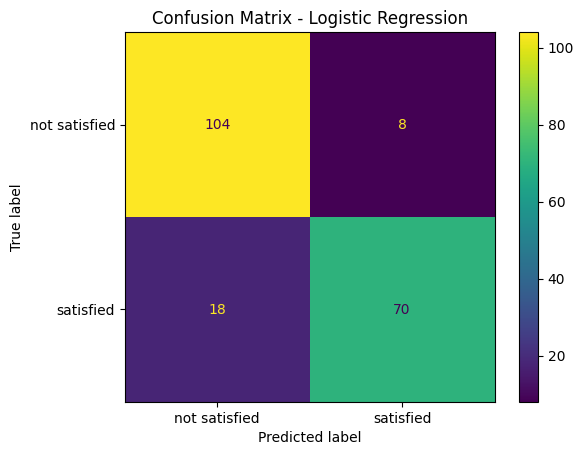

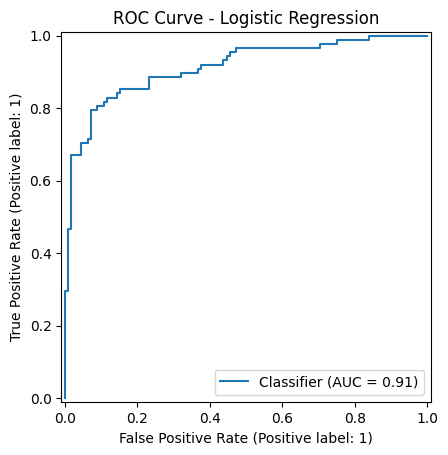

In [45]:
logreg = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

logreg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg)
])

logreg_metrics, logreg_fitted = evaluate_model(
    "Logistic Regression",
    logreg_clf,
    X_train, y_train,
    X_val, y_val,
    save_plots=True
)

## 8. Model 2: XGBoost (Advanced)

XGBoost kuat untuk data tabular dan sering memberikan performa tinggi.

Tambahan: Untuk imbalance, kita set `scale_pos_weight = neg/pos` dari data train split.


scale_pos_weight: 1.2727272727272727

=== XGBoost (Validation) ===
positive_class : 1
threshold      : 0.64
  accuracy: 0.9400
 precision: 0.9419
    recall: 0.9205
        f1: 0.9310
   roc_auc: 0.9726


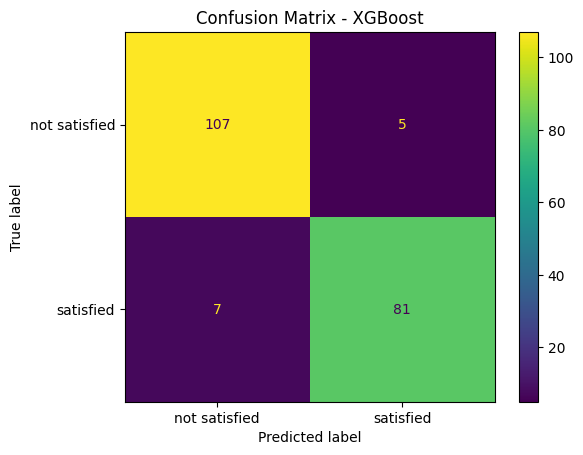

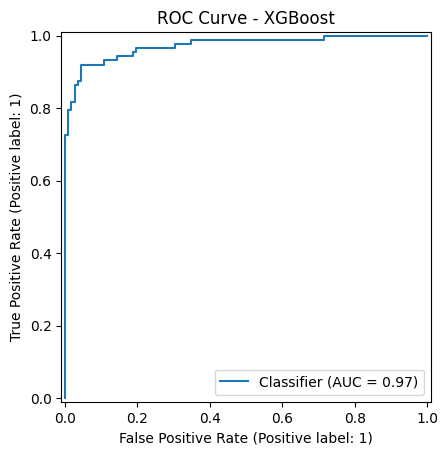

In [46]:
# scale_pos_weight untuk imbalance (opsional tapi membantu)
pos = int(y_train.sum())
neg = int((1 - y_train).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print("scale_pos_weight:", scale_pos_weight)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

xgb_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb)
])

xgb_metrics, xgb_fitted = evaluate_model(
    "XGBoost",
    xgb_clf,
    X_train, y_train,
    X_val, y_val,
    save_plots=True
)

## 9. Perbandingan Model (Minimal 2 Algoritma)

Pemilihan model terbaik berdasarkan **F1-score** (utama).


In [47]:
results = pd.DataFrame([logreg_metrics, xgb_metrics]).set_index("model")
results = results.sort_values(by="f1", ascending=False)
display(results)

best_name = results.index[0]
print("Best model (by F1):", best_name)

,positive_class,threshold,accuracy,precision,recall,f1,roc_auc
model,,,,,,,
XGBoost,1,0.64,0.94,0.941860,0.920455,0.931034,0.972606
Logistic Regression,1,0.74,0.87,0.897436,0.795455,0.843373,0.913352


Best model (by F1): XGBoost


## 10. Interpretasi Fitur

Kita ekstrak nama fitur setelah OneHotEncoding agar:
- koefisien Logistic Regression bisa dibaca per fitur
- feature importance XGBoost bisa ditampilkan per fitur


In [48]:
def get_feature_names(preprocess_fitted, numeric_features, categorical_features):
    num_names = list(numeric_features)
    ohe = preprocess_fitted.named_transformers_["cat"].named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()
    return num_names + cat_names

# Feature names khusus untuk masing-masing model (lebih aman)
pre_log = logreg_fitted.named_steps["preprocess"]
pre_xgb = xgb_fitted.named_steps["preprocess"]

feature_names_log = get_feature_names(pre_log, numeric_features, categorical_features)
feature_names_xgb = get_feature_names(pre_xgb, numeric_features, categorical_features)

print("Total transformed features (logreg):", len(feature_names_log))
print("Total transformed features (xgb)   :", len(feature_names_xgb))
print("Contoh feature names:", feature_names_log[:15])

Total transformed features (logreg): 27
Total transformed features (xgb)   : 27
Contoh feature names: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service']


### 10A. Logistic Regression: Top Koefisien (|coef| terbesar)

Koefisien besar menandakan fitur berpengaruh kuat terhadap prediksi.


Top-15 fitur paling berpengaruh (berdasarkan |coef|):


,feature,coef,abs_coef,effect
22,Type of Travel_Business travel,1.478377,1.478377,meningkatkan satisfied
23,Type of Travel_Personal Travel,-1.478085,1.478085,menurunkan satisfied
20,Customer Type_Loyal Customer,0.881954,0.881954,meningkatkan satisfied
21,Customer Type_disloyal Customer,-0.881661,0.881661,menurunkan satisfied
17,Arrival Delay in Minutes,-0.859373,0.859373,menurunkan satisfied
16,Departure Delay in Minutes,0.623957,0.623957,meningkatkan satisfied
7,Online boarding,0.581413,0.581413,meningkatkan satisfied
10,On-board service,0.532047,0.532047,meningkatkan satisfied
2,Inflight wifi service,0.475945,0.475945,meningkatkan satisfied
13,Checkin service,0.453428,0.453428,meningkatkan satisfied


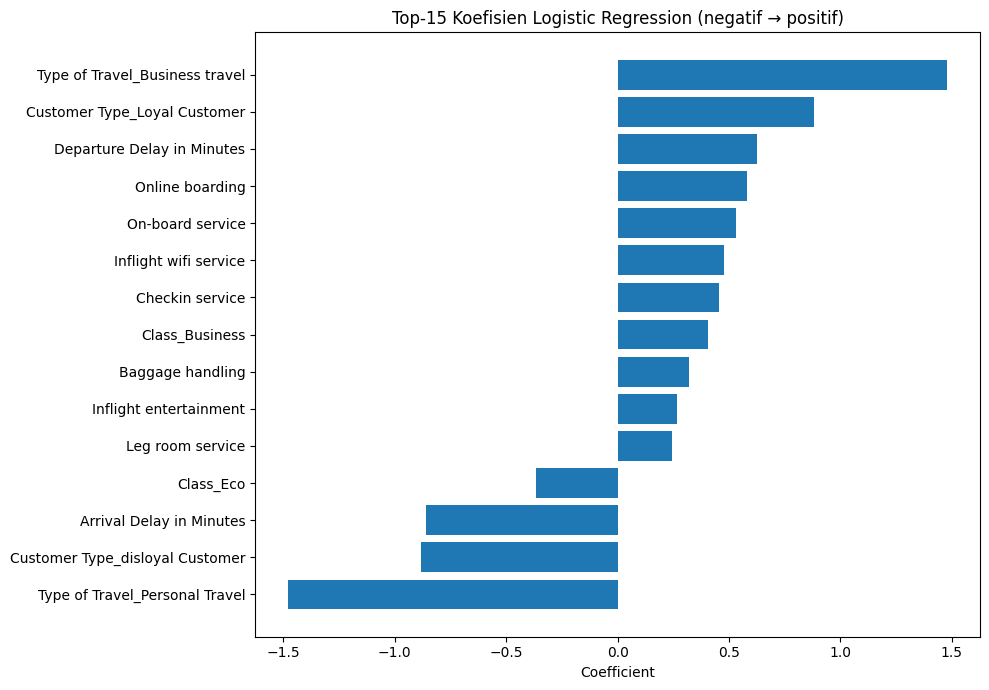

Top-10 fitur yang MENINGKATKAN peluang 'satisfied':


,feature,coef
22,Type of Travel_Business travel,1.478377
20,Customer Type_Loyal Customer,0.881954
16,Departure Delay in Minutes,0.623957
7,Online boarding,0.581413
10,On-board service,0.532047
2,Inflight wifi service,0.475945
13,Checkin service,0.453428
24,Class_Business,0.406020
12,Baggage handling,0.319571
9,Inflight entertainment,0.267194


Top-10 fitur yang MENURUNKAN peluang 'satisfied':


,feature,coef
23,Type of Travel_Personal Travel,-1.478085
21,Customer Type_disloyal Customer,-0.881661
17,Arrival Delay in Minutes,-0.859373
25,Class_Eco,-0.364998
18,Gender_Female,-0.203519
6,Food and drink,-0.170867
3,Departure/Arrival time convenient,-0.158003
4,Ease of Online booking,-0.130881
26,Class_Eco Plus,-0.040729
0,Age,-0.006217


Saved full coefficients to: outputs\logreg_coefficients.csv


In [49]:
# Pastikan model sudah fit (logreg_fitted sudah fit dari evaluate_model)
coef = logreg_fitted.named_steps["model"].coef_.ravel()

# Safety check: pastikan panjang koefisien sama dengan jumlah feature_names
if len(coef) != len(feature_names_log):
    raise ValueError(
        f"Mismatch jumlah fitur! len(coef)={len(coef)} vs len(feature_names_log)={len(feature_names_log)}"
    )

coef_df = pd.DataFrame({
    "feature": feature_names_log,
    "coef": coef
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["effect"] = np.where(coef_df["coef"] >= 0, "meningkatkan satisfied", "menurunkan satisfied")

# ---- 1) Tabel Top-15 berdasarkan |coef| terbesar
top15 = coef_df.sort_values("abs_coef", ascending=False).head(15)
print("Top-15 fitur paling berpengaruh (berdasarkan |coef|):")
display(top15[["feature", "coef", "abs_coef", "effect"]])

# ---- 2) Plot Top-15 koefisien (urut negatif → positif)
top15_plot = top15.sort_values("coef", ascending=True)

plt.figure(figsize=(10, 7))
plt.barh(top15_plot["feature"], top15_plot["coef"])
plt.title("Top-15 Koefisien Logistic Regression (negatif → positif)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "coef_logreg_top15.png"), bbox_inches="tight", dpi=150)
plt.show()

# ---- 3) Top-10 positif (paling meningkatkan peluang satisfied)
top_pos = coef_df.sort_values("coef", ascending=False).head(10)
print("Top-10 fitur yang MENINGKATKAN peluang 'satisfied':")
display(top_pos[["feature", "coef"]])

# ---- 4) Top-10 negatif (paling menurunkan peluang satisfied)
top_neg = coef_df.sort_values("coef", ascending=True).head(10)
print("Top-10 fitur yang MENURUNKAN peluang 'satisfied':")
display(top_neg[["feature", "coef"]])

# (Opsional) simpan tabel koefisien ke CSV untuk dokumentasi laporan
coef_csv_path = os.path.join(OUTPUT_DIR, "logreg_coefficients.csv")
coef_df.sort_values("abs_coef", ascending=False).to_csv(coef_csv_path, index=False)
print("Saved full coefficients to:", coef_csv_path)


### 10B. XGBoost: Feature Importance (Top-15)

Feature importance menunjukkan fitur apa yang paling berpengaruh pada model XGBoost.


,feature,importance
7,Online boarding,0.145949
24,Class_Business,0.123092
22,Type of Travel_Business travel,0.117216
23,Type of Travel_Personal Travel,0.088868
21,Customer Type_disloyal Customer,0.074279
2,Inflight wifi service,0.060987
9,Inflight entertainment,0.056460
20,Customer Type_Loyal Customer,0.041558
25,Class_Eco,0.026895
12,Baggage handling,0.024665


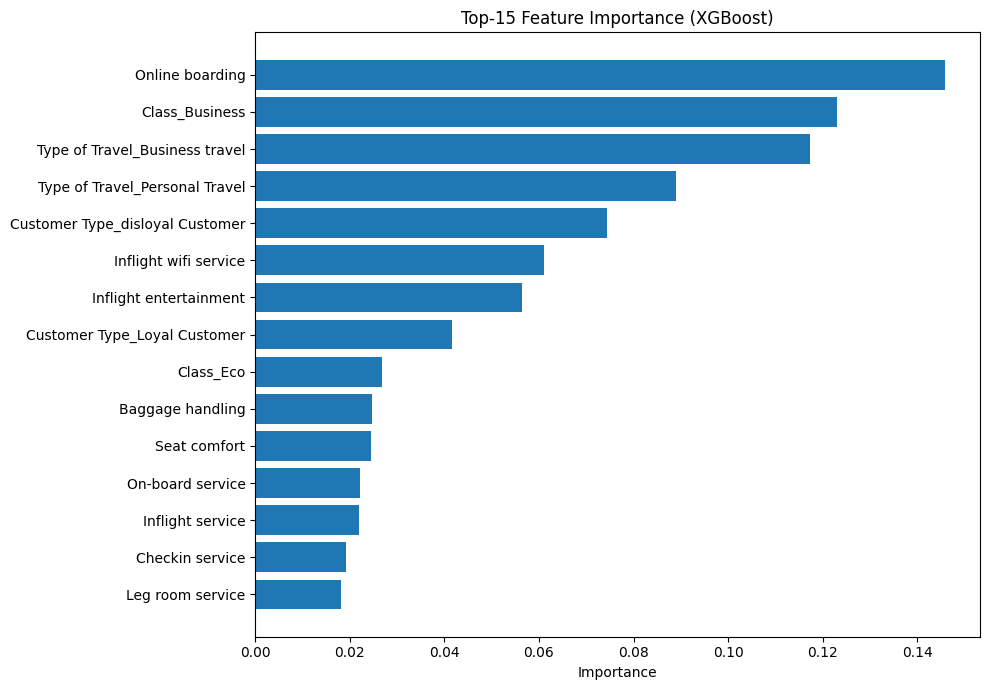

In [50]:
importances = xgb_fitted.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names_xgb, "importance": importances}).sort_values("importance", ascending=False)

display(imp_df.head(15))

top = imp_df.head(15).iloc[::-1]
plt.figure(figsize=(10, 7))
plt.barh(top["feature"], top["importance"])
plt.title("Top-15 Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "feature_importance_xgboost_top15.png"), bbox_inches="tight", dpi=150)
plt.show()

## 11. Evaluasi Final pada Test Set

Test set digunakan sebagai simulasi data baru untuk mengecek generalisasi model.


=== FINAL TEST METRICS (model selected by validation F1) ===
Model     : XGBoost
Threshold : 0.64
Accuracy  : 0.909
Precision : 0.941747572815534
Recall    : 0.8527472527472527
F1        : 0.895040369088812
ROC-AUC   : 0.9762032462949894


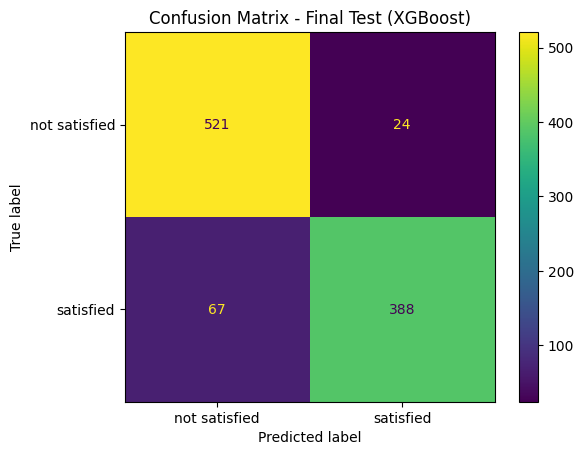

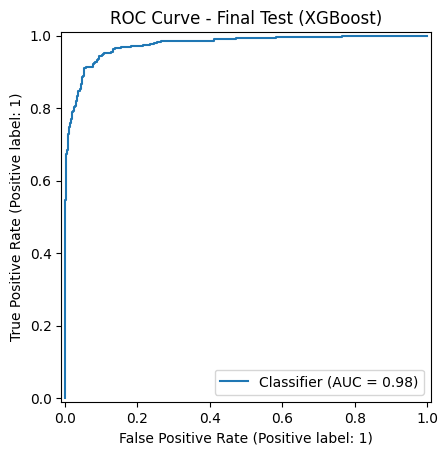

In [51]:
# --- PERBAIKAN NOMOR 11 ---
X_test = df_test.drop(columns=[TARGET]).copy()

# drop id/ID supaya konsisten seperti train
for c in ["id", "ID"]:
    if c in X_test.columns:
        X_test.drop(columns=[c], inplace=True)

y_test = (df_test[TARGET] == "satisfied").astype(int)

best_model = xgb_fitted if best_name == "XGBoost" else logreg_fitted

thr_map = {
    "Logistic Regression": logreg_metrics.get("threshold", 0.5),
    "XGBoost": xgb_metrics.get("threshold", 0.5),
}
thr_used = thr_map.get(best_name, 0.5)

y_test_proba = _positive_class_proba(best_model, X_test, positive_class=1)
y_test_pred  = (y_test_proba >= thr_used).astype(int)

print("=== FINAL TEST METRICS (model selected by validation F1) ===")
print("Model     :", best_name)
print("Threshold :", round(thr_used, 2))
print("Accuracy  :", accuracy_score(y_test, y_test_pred))
print("Precision :", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall    :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1        :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC   :", roc_auc_score(y_test, y_test_proba))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    display_labels=["not satisfied", "satisfied"],
    values_format="d"
)
plt.title(f"Confusion Matrix - Final Test ({best_name})")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title(f"ROC Curve - Final Test ({best_name})")
plt.show()


## 12. Refit Model Terbaik pada Data Train Penuh + Simpan (joblib)

Setelah memilih model terbaik di validation, kita **fit ulang** pada seluruh data train,
lalu simpan menggunakan joblib untuk deployment.


In [52]:
# Fit ulang pada full train untuk deployment (best model)
if best_name == "XGBoost":
    final_model = xgb_clf.fit(X, y_bin)
else:
    final_model = logreg_clf.fit(X, y_bin)

best_model_path = os.path.join(OUTPUT_DIR, "best_model.joblib")
joblib.dump(final_model, best_model_path)
print("Saved best model to:", best_model_path)

# =========================
# Tambahan: Simpan juga 2 model (LogReg & XGBoost) untuk perbandingan di Streamlit
# =========================
logreg_path = os.path.join(OUTPUT_DIR, "logreg_model.joblib")
xgb_path    = os.path.join(OUTPUT_DIR, "xgb_model.joblib")

# Fit ulang masing-masing model pada full train
logreg_full = logreg_clf.fit(X, y_bin)
xgb_full    = xgb_clf.fit(X, y_bin)

# Simpan keduanya
joblib.dump(logreg_full, logreg_path)
joblib.dump(xgb_full, xgb_path)

print("Saved Logistic Regression model to:", logreg_path)
print("Saved XGBoost model to:", xgb_path)

Saved best model to: outputs\best_model.joblib
Saved Logistic Regression model to: outputs\logreg_model.joblib
Saved XGBoost model to: outputs\xgb_model.joblib


## 13. (Opsional) Simpan Prediksi Test ke CSV

In [53]:
test_pred_df = df_test.copy()

# 2) Hitung threshold terbaik untuk *final_model* berdasarkan validation set (X_val, y_val)
#    Ini membuat threshold benar-benar konsisten dengan model yang dipakai deploy (final_model).

# Ambil proba final_model pada validation
y_val_proba_final = _positive_class_proba(final_model, X_val, positive_class=1)

# Cari threshold terbaik untuk F1 (menggunakan fungsi yang sudah kamu punya)
thr_final, best_f1_final = _best_threshold_by_f1(y_val, y_val_proba_final, step=0.01)

print(f"[Final Model] Best threshold from VAL = {thr_final:.2f} | F1 = {best_f1_final:.4f}")

# 3) Prediksi proba pada test menggunakan final_model (konsisten)
test_pred_df["proba_satisfied"] = _positive_class_proba(final_model, X_test, positive_class=1)

# 4) Label prediksi menggunakan threshold final_model
test_pred_df["pred_label"] = np.where(
    test_pred_df["proba_satisfied"] >= thr_final,
    "satisfied",
    "neutral or dissatisfied"
)

# (opsional) simpan juga prediksi biner
test_pred_df["pred_bin"] = (test_pred_df["proba_satisfied"] >= thr_final).astype(int)

# 5) Simpan kolom dengan aman (kalau TARGET tidak ada, tetap bisa save)
cols_to_save = ["pred_label", "proba_satisfied", "pred_bin"]
if TARGET in test_pred_df.columns:
    cols_to_save = [TARGET] + cols_to_save

out_csv = os.path.join(OUTPUT_DIR, "prediksi_test.csv")
test_pred_df[cols_to_save].to_csv(out_csv, index=False)

print("Saved test predictions to:", out_csv)
test_pred_df[cols_to_save].head()


[Final Model] Best threshold from VAL = 0.24 | F1 = 1.0000
Saved test predictions to: outputs\prediksi_test.csv


,satisfaction,pred_label,proba_satisfied,pred_bin
0,satisfied,satisfied,0.996794,1
1,satisfied,satisfied,0.992581,1
2,neutral or dissatisfied,neutral or dissatisfied,0.001847,0
3,satisfied,satisfied,0.852976,1
4,satisfied,neutral or dissatisfied,0.086829,0
